## In this notebook, we take a step back and try a rule based model for the flood mapping competition
https://zindi.africa/competitions/inundata-mapping-floods-in-south-africa/data


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = '/raid/ml/flood'
train_path = os.path.join(path,'Train.csv')
train_df = pd.read_csv(train_path)
train_df.head()

,event_id,precipitation,label
0,id_spictby0jfsb_X_0,0.000000,0
1,id_spictby0jfsb_X_1,0.095438,0
2,id_spictby0jfsb_X_2,1.949560,0
3,id_spictby0jfsb_X_3,3.232160,0
4,id_spictby0jfsb_X_4,0.000000,0


In [3]:
test_path = os.path.join(path,'Test.csv')
test_df = pd.read_csv(test_path)
test_df.head()

,event_id,precipitation
0,id_j7b6sokflo4k_X_0,0.00000
1,id_j7b6sokflo4k_X_1,3.01864
2,id_j7b6sokflo4k_X_2,0.00000
3,id_j7b6sokflo4k_X_3,16.61520
4,id_j7b6sokflo4k_X_4,2.56706


In [4]:
# Extract location and day from event_id
train_df['location'] = train_df['event_id'].apply(lambda x: x.split('_')[1])
train_df['day'] = train_df['event_id'].apply(lambda x: int(x.split('_')[-1])).astype(int)

test_df['location'] = test_df['event_id'].apply(lambda x: x.split('_')[1])
test_df['day'] = test_df['event_id'].apply(lambda x: int(x.split('_')[-1])).astype(int)

train_df.head()

,event_id,precipitation,label,location,day
0,id_spictby0jfsb_X_0,0.000000,0,spictby0jfsb,0
1,id_spictby0jfsb_X_1,0.095438,0,spictby0jfsb,1
2,id_spictby0jfsb_X_2,1.949560,0,spictby0jfsb,2
3,id_spictby0jfsb_X_3,3.232160,0,spictby0jfsb,3
4,id_spictby0jfsb_X_4,0.000000,0,spictby0jfsb,4


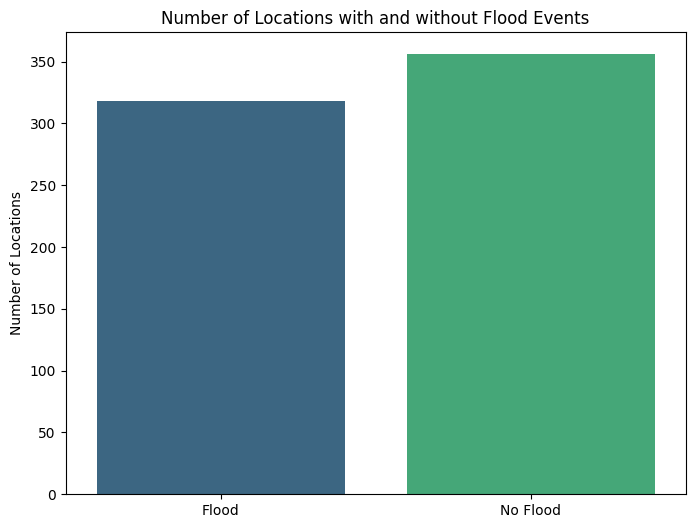

In [5]:
# --- Visualization 1: Count of Locations with and without Floods ---
flood_locations = train_df[train_df['label'] == 1]['location'].unique()
num_locations = train_df['location'].nunique()
no_flood_locations = num_locations - len(flood_locations)
plt.figure(figsize=(8, 6))
sns.barplot(x=['Flood', 'No Flood'], y=[len(flood_locations), no_flood_locations], palette='viridis')
plt.title("Number of Locations with and without Flood Events")
plt.ylabel("Number of Locations")
plt.show()

In [6]:
flood_percentage = len(flood_locations) / train_df['location'].nunique()
flood_percentage

0.47181008902077154

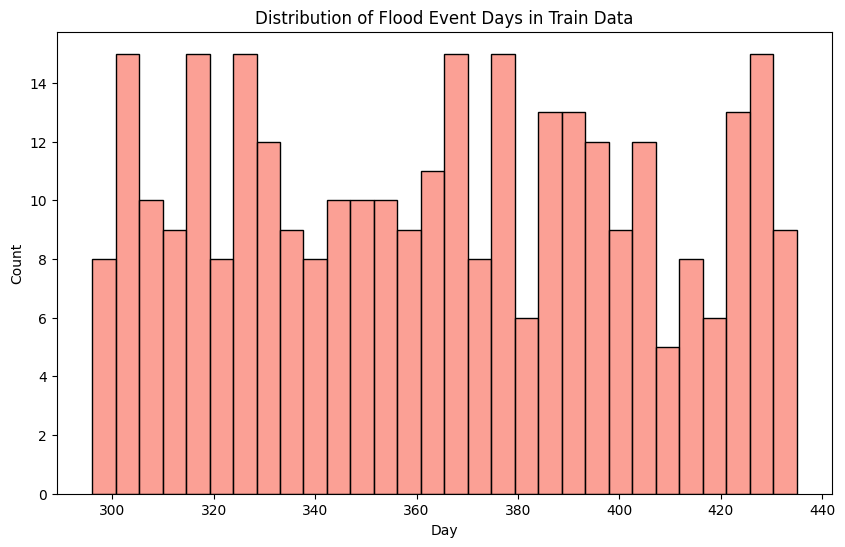

In [7]:
# Calculate min and max flood days for each location
flood_days = train_df[train_df['label'] == 1]['day']
# --- Visualization 2: Distribution of Flood Event Days in Train Data ---
plt.figure(figsize=(10, 6))
sns.histplot(flood_days, bins=30, kde=False, color='salmon')
plt.title("Distribution of Flood Event Days in Train Data")
plt.xlabel("Day")
plt.ylabel("Count")
plt.show()


In [8]:
ndays = flood_days.max() - flood_days.min()
flood_days.min(), flood_days.max(), ndays

(296, 435, 139)

In [9]:
mask = (train_df.day>=flood_days.min()) & (train_df.day<=flood_days.max())
train_df['prob'] = 0.0
train_df.loc[mask,'prob'] = flood_percentage/ndays
logloss = log_loss(train_df['label'], train_df['prob'])
print(f"Log Loss on Train: {logloss}")

Log Loss on Train: 0.004324598389247731


In [10]:
mask = (test_df.day>=flood_days.min()) & (test_df.day<=flood_days.max())
test_df['label'] = 0.0
test_df.loc[mask,'label'] = flood_percentage/ndays
# Save submission CSV
test_df[['event_id','label']].to_csv('submission_no_ml.csv', index=False, float_format='%.10f')

### The rule based submission got 0.004810266 on LB, better than the 0.006430 Deepmind benchmark!
https://zindi.africa/competitions/inundata-mapping-floods-in-south-africa/discussions/23577